In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


split by max chan as the first step

In [6]:
max_chan_trials = []
for i in range(stimulus_onset_times.shape[0]):
    mask = np.logical_and(spikes_indices[:,0] >= stimulus_onset_times[i]*samp_freq-samp_freq*0.5,   
                         spikes_indices[:,0] <= stimulus_onset_times[i]*samp_freq+samp_freq )    
    trial = spikes_indices[mask,:]
    max_chan_trials.append(trial)

In [7]:
trials_ids = np.arange(len(trials))
max_chan_unsorted = np.vstack([max_chan_trials[i] for i in trials_ids]) 
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:]

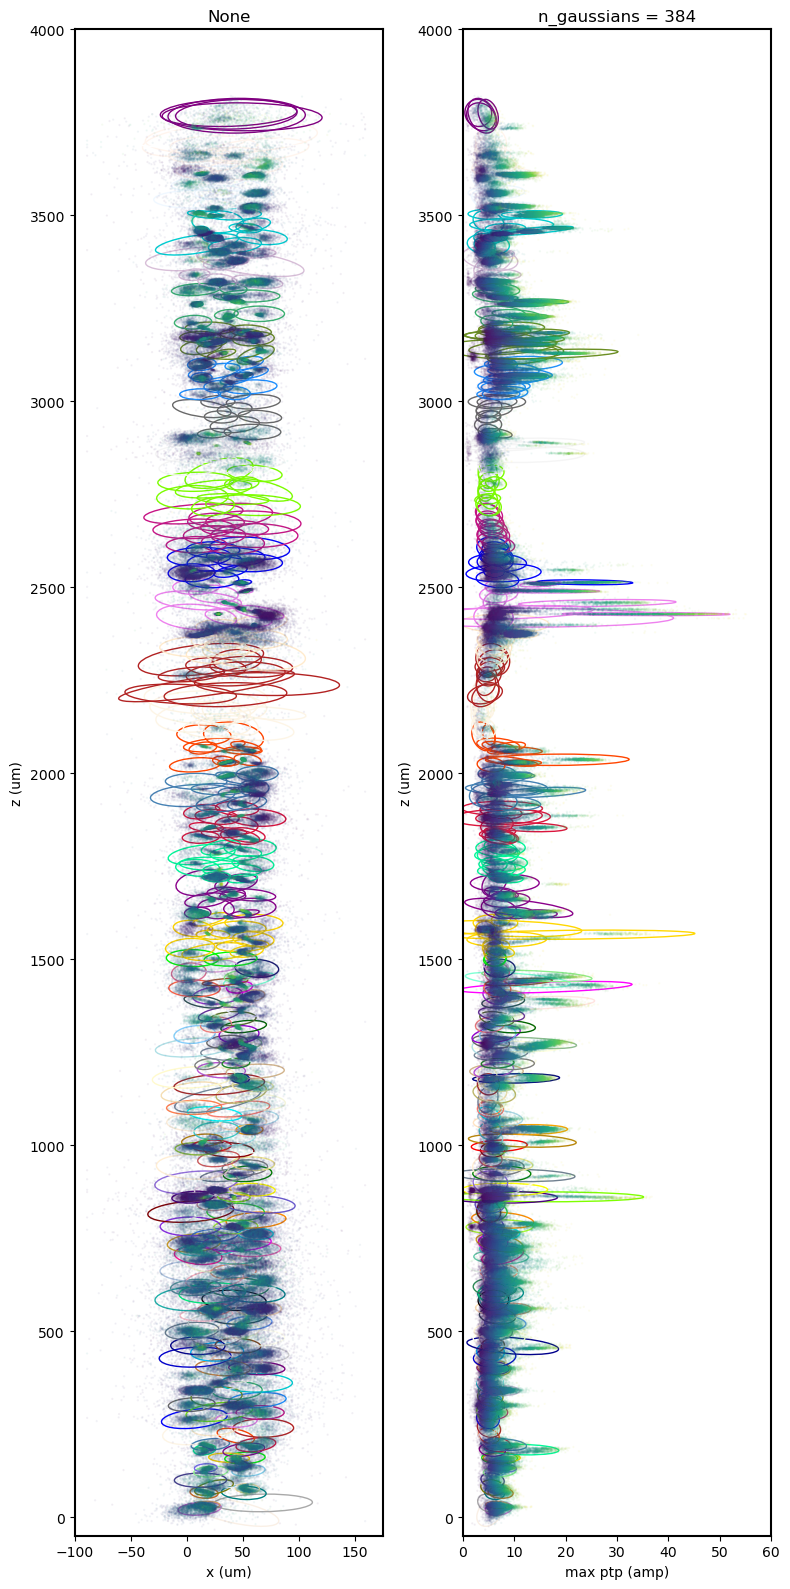

In [8]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_unsorted[:,1], np.unique(max_chan_unsorted[:,1]), display_all_spikes=False, n_spikes_display=5_000)

zoom in to split one channel

In [9]:
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from clusterless.viz_tools import confidence_ellipse

def plot_gmm_cluster_bounds(sub_id, data, labels, labels_display, display_all_spikes=False, n_spikes_display=30_000, figure_size=(8,16), title=None, save_fig=False):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for i in np.unique(labels_display):
        if i >= 148:
            c = int(i.copy()) // 10  # only 148 colors available for plotting
        else:
            c = int(i.copy())
        if len(data[labels == i, 0]) > 10:
            confidence_ellipse(data[labels == i, 0], data[labels == i, 1], 
                               axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(data[labels == i, 2], data[labels == i, 1], 
                               axes[1], alpha=1., edgecolor=colors[c], linewidth=1.,  zorder=0)
            if display_all_spikes:
                axes[0].scatter(data[labels == i][:,0], data[labels == i][:,1], 
                            s=.5, alpha=0.05, c=data[labels == i][:n_spikes_display,2])
                axes[1].scatter(data[labels == i][:,2], data[labels == i][:,1], 
                            s=.5, alpha=0.05, c=data[labels == i][:n_spikes_display,2])
            else:
                axes[0].scatter(data[labels == i][:n_spikes_display,0], data[labels == i][:n_spikes_display,1], 
                                s=.5, alpha=0.05, c=data[labels == i][:n_spikes_display,2])
                axes[1].scatter(data[labels == i][:n_spikes_display,2], data[labels == i][:n_spikes_display,1], 
                                s=.5, alpha=0.05, c=data[labels == i][:n_spikes_display,2])
            axes[0].set_xlim(-100, 175)
            axes[0].set_ylim(data[labels == i, 1].min()-250, data[labels == i, 1].min()+250)
            axes[0].set_xlabel('x (um)')
            axes[0].set_ylabel('z (um)')
            axes[0].set_title(f'{title}')
            axes[1].set_xlim(0, 60)
            axes[1].set_ylim(data[labels == i, 1].min()-250, data[labels == i, 1].min()+250)
            axes[1].set_xlabel('max ptp (amp)')
            axes[1].set_ylabel('z (um)')
            axes[1].set_title(f'n_gaussians = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1.5)
        axes[1].spines[ax].set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

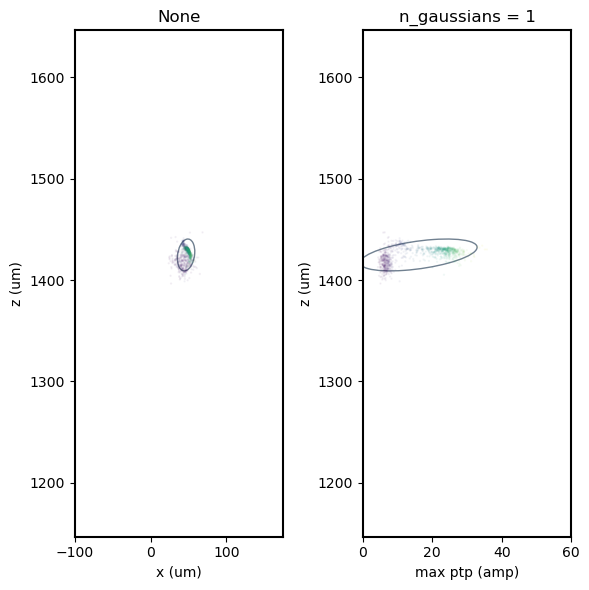

In [10]:
idx = np.unique(max_chan_unsorted[:,1])[140] # 91, 99, 101, 116, 124, 126, 128, 134, 136, 138, 140,  
sub_spike_train = structured_unsorted[max_chan_unsorted[:,1] == idx]
plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_unsorted[:,1], idx, display_all_spikes=True, figure_size=(6,6))

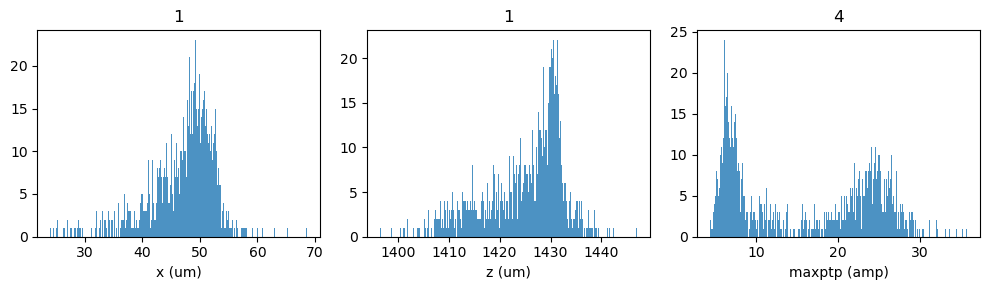

In [12]:
p_val = 0.05,
n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0]), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1]), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2]), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].hist(sub_spike_train[:,0], 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_spike_train[:,1], 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_spike_train[:,2], 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [13]:
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          # weight_concentration_prior_type='dirichlet_distribution',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_train)

In [14]:
sub_labels = sub_gmm.predict(sub_spike_train)

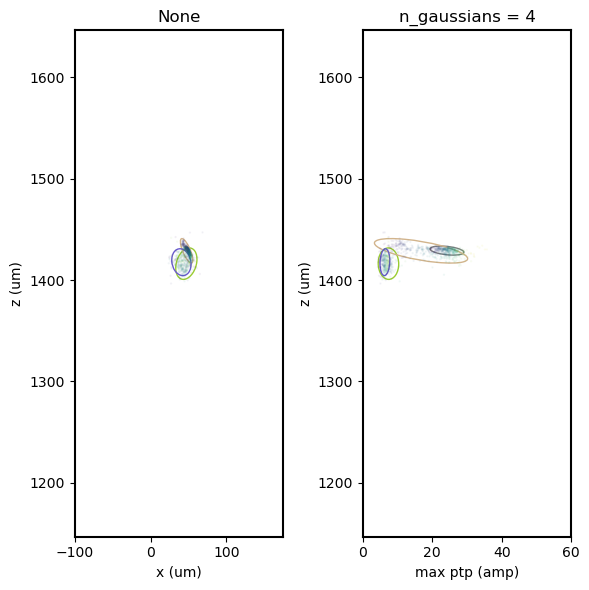

In [15]:
plot_gmm_cluster_bounds(sub_id, sub_spike_train, sub_labels, np.unique(sub_labels), display_all_spikes=True, figure_size=(6,6))

In [274]:
multi_modal_dict = {}
sub_spike_train_lst = []
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
p_val = .05
for label in np.unique(max_chan_unsorted[:,1]):
    sub_spike_train = structured_unsorted[max_chan_unsorted[:,1] == label]
    sub_spike_train_lst.append(sub_spike_train)
    n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0]), alpha=p_val).run())
    n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1]), alpha=p_val).run())
    n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2]), alpha=p_val).run())
    n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
    if n_gaussians > 1:
        print(f'unit {label} has {n_gaussians} modes ...')
        multi_modal_dict.update({label: n_gaussians})
    sub_gmm = GaussianMixture(n_components=n_gaussians, 
                      max_iter=1000,
                      covariance_type='full',
                      init_params='kmeans', warm_start=False, verbose=0)
    sub_gmm.fit(sub_spike_train)
    sub_labels = sub_gmm.predict(sub_spike_train)
    sub_weights = [np.sum(sub_labels == i)/len(structured_unsorted) for i in range(n_gaussians)]
    sub_weights_lst.append(sub_weights)
    sub_means_lst.append(sub_gmm.means_)
    sub_covs_lst.append(sub_gmm.covariances_)

unit 12 has 2 modes ...
unit 17 has 2 modes ...
unit 38 has 2 modes ...
unit 45 has 2 modes ...
unit 69 has 2 modes ...
unit 70 has 2 modes ...
unit 76 has 7 modes ...
unit 78 has 2 modes ...
unit 84 has 2 modes ...
unit 85 has 3 modes ...
unit 87 has 7 modes ...
unit 91 has 2 modes ...
unit 99 has 3 modes ...
unit 101 has 2 modes ...
unit 116 has 4 modes ...
unit 124 has 6 modes ...
unit 126 has 4 modes ...
unit 128 has 3 modes ...
unit 130 has 3 modes ...
unit 132 has 2 modes ...
unit 134 has 2 modes ...
unit 136 has 3 modes ...
unit 138 has 2 modes ...
unit 140 has 4 modes ...
unit 141 has 2 modes ...
unit 142 has 3 modes ...
unit 143 has 4 modes ...
unit 144 has 2 modes ...
unit 145 has 3 modes ...
unit 154 has 2 modes ...
unit 155 has 2 modes ...
unit 157 has 3 modes ...
unit 158 has 2 modes ...
unit 159 has 2 modes ...
unit 160 has 3 modes ...
unit 162 has 2 modes ...
unit 166 has 2 modes ...
unit 168 has 2 modes ...
unit 172 has 2 modes ...
unit 173 has 3 modes ...
unit 174 has 

In [275]:
multi_modal_ids = list(multi_modal_dict.keys())
uni_modal_ids = list(set(np.unique(max_chan_unsorted[:,1])).difference(set(multi_modal_ids)))

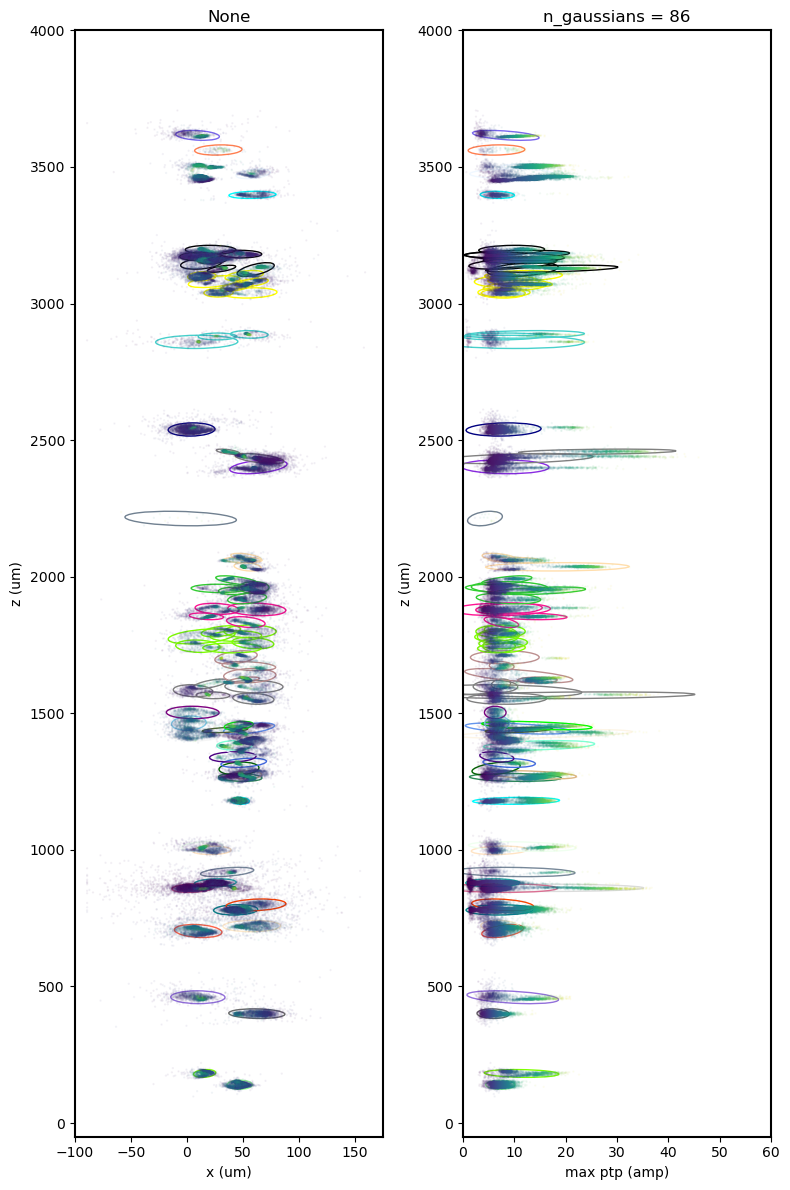

In [267]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_unsorted[:,1], multi_modal_ids, figure_size=(8,12), display_all_spikes=True)

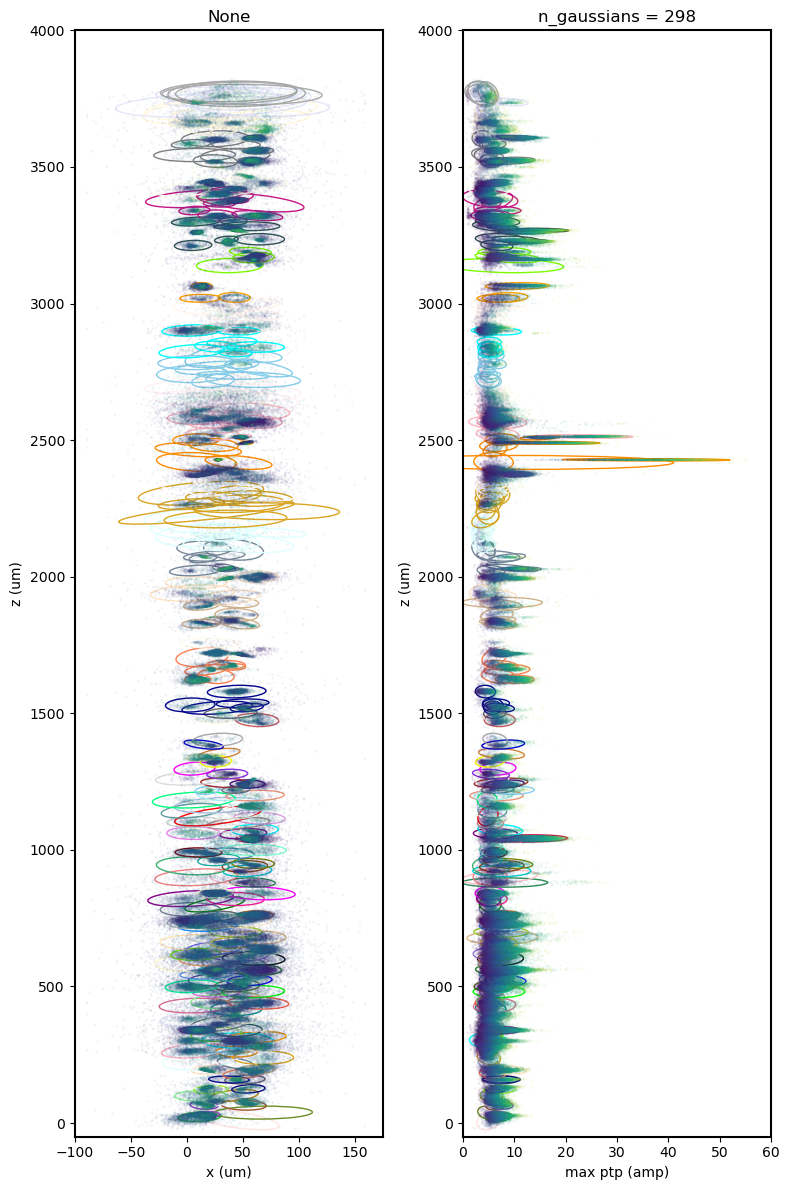

In [268]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_unsorted[:,1], uni_modal_ids, figure_size=(8,12), display_all_spikes=True)

In [276]:
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

In [277]:
max_chan_gmm = GaussianMixture(n_components=len(sub_weights), covariance_type='full')
max_chan_gmm.weights_ = sub_weights
max_chan_gmm.means_ = sub_means
max_chan_gmm.covariances_ = sub_covs
max_chan_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [278]:
max_chan_labels = max_chan_gmm.predict(structured_unsorted)
max_chan_probs = max_chan_gmm.predict_proba(structured_unsorted)

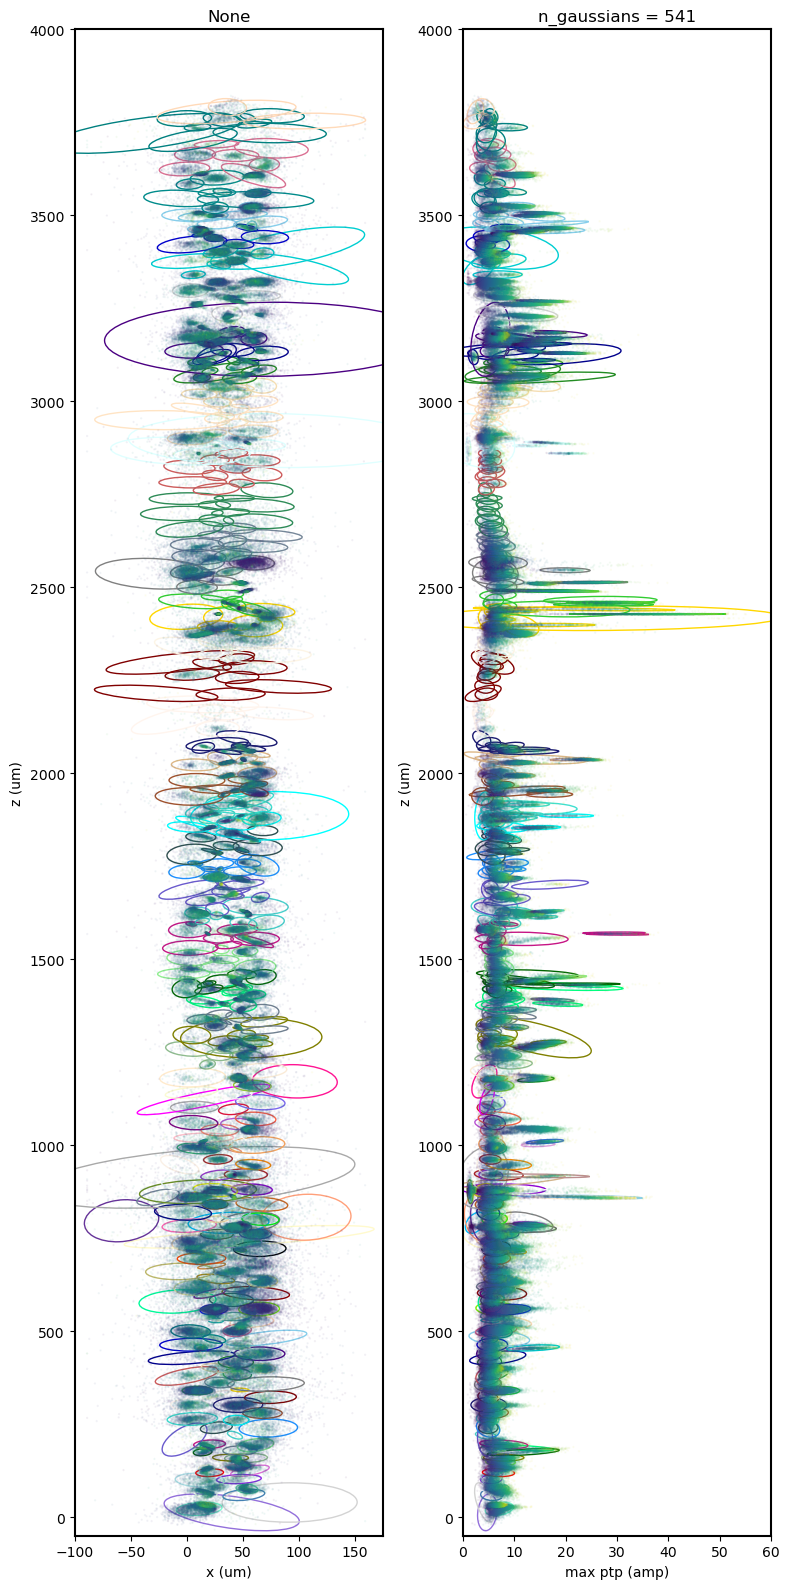

In [279]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, max_chan_labels, max_chan_labels, display_all_spikes=False, n_spikes_display=5_000)

In [281]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, max_chan_labels, max_chan_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 541, 30)
clusterless neural projections shape: (230, 541, 15)
clusterless neural reconstructions shape: (230, 541, 30)


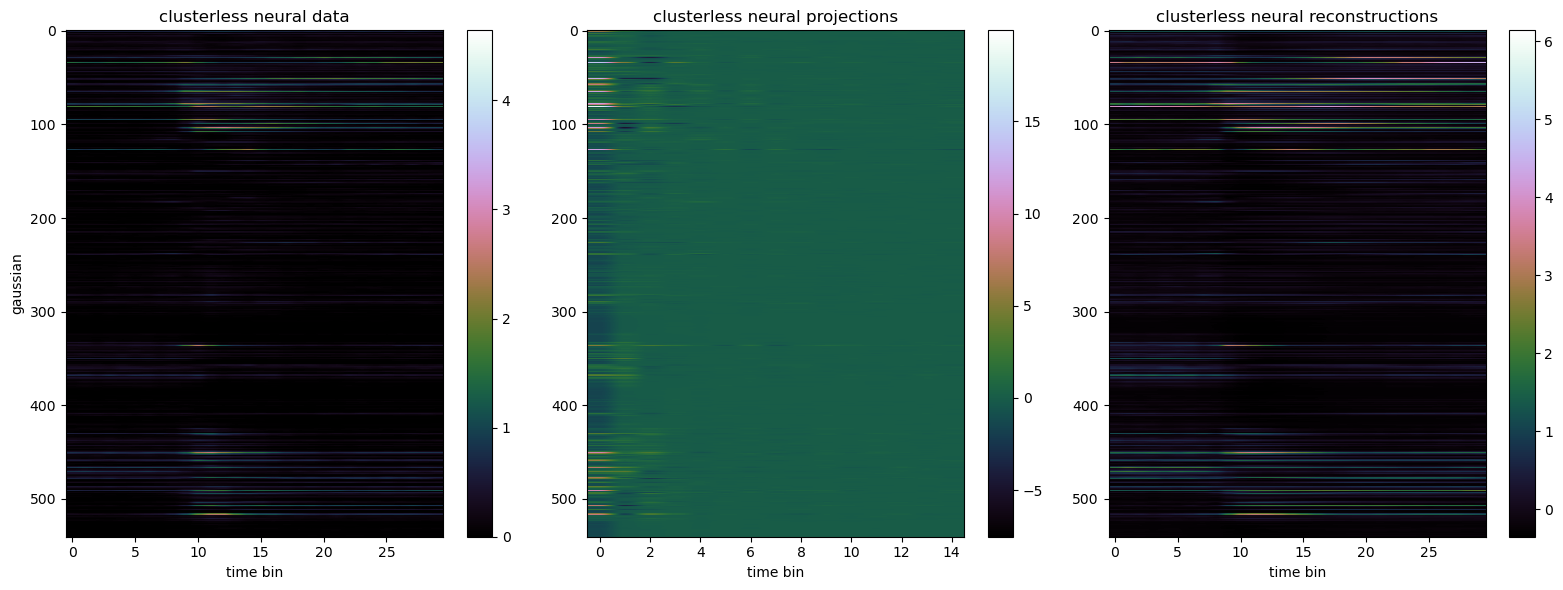

In [282]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [283]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.935 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.994
choice fold 3 test accuracy: 0.957 auc: 0.994
choice fold 4 test accuracy: 0.935 auc: 0.986
choice fold 5 test accuracy: 0.957 auc: 0.998
choice mean of 5-fold cv accuracy: 0.948 auc: 0.991
choice sd of 5-fold cv accuracy: 0.011 auc: 0.005
stimulus fold 1 test accuracy: 0.261 auc: 0.773
stimulus fold 2 test accuracy: 0.261 auc: 0.799
stimulus fold 3 test accuracy: 0.370 auc: 0.806
stimulus fold 4 test accuracy: 0.326 auc: 0.807
stimulus fold 5 test accuracy: 0.348 auc: 0.816
stimulus mean of 5-fold cv accuracy: 0.313 auc: 0.800
stimulus sd of 5-fold cv accuracy: 0.045 auc: 0.015


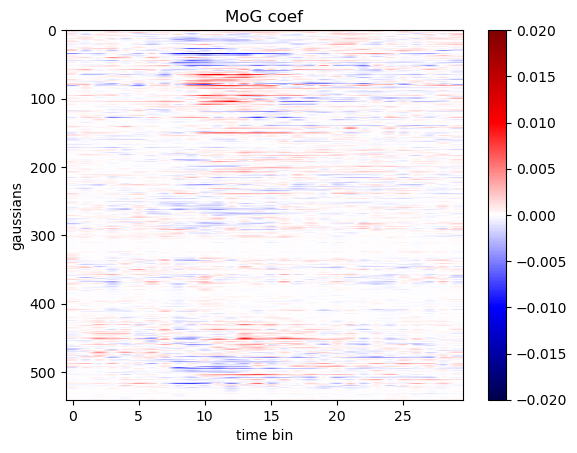

In [284]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()